# Polynomial Interpolation
## January 20th, 2022
### Overview: The space of polynomials is dense in the space of continous functions, thus any continuous function can be approximated to an arbitrary degree of accuracy. This process is polynomial interpolation and is demonstrated here

In [1]:
import numpy as np
from numpy.fft import fft
from matplotlib import pyplot as plt
from scipy.interpolate import BarycentricInterpolator

In [2]:
# Problems 1 and 2
def lagrange(xint, yint, points):
    """Find an interpolating polynomial of lowest degree through the points
    (xint, yint) using the Lagrange method and evaluate that polynomial at
    the specified points.

    Parameters:
        xint ((n,) ndarray): x values to be interpolated.
        yint ((n,) ndarray): y values to be interpolated.
        points((m,) ndarray): x values at which to evaluate the polynomial.

    Returns:
        ((m,) ndarray): The value of the polynomial at the specified points.
    """
    #calculating each denominator
    vals = []
    for xj in xint:
        denom = 1
        numer = 1
        for xk in xint:
            if xk != xj:
                denom *= xj-xk
                numer *= (points-xk)
        vals.append(numer/denom)
    
    #creating nxm matrix of the points
    nxmVals = np.array(vals)
    
    #summing
    poly = 0
    for i, y in enumerate(yint):
        poly += y*nxmVals[i]
        
    return poly

In [3]:
# Problems 3 and 4
class Barycentric:
    """Class for performing Barycentric Lagrange interpolation.

    Attributes:
        w ((n,) ndarray): Array of Barycentric weights.
        n (int): Number of interpolation points.
        x ((n,) ndarray): x values of interpolating points.
        y ((n,) ndarray): y values of interpolating points.
    """

    def __init__(self, xint, yint):
        """Calculate the Barycentric weights using initial interpolating points.

        Parameters:
            xint ((n,) ndarray): x values of interpolating points.
            yint ((n,) ndarray): y values of interpolating points.
        """
        #saving xint, yint, and their length as attributes
        self.xint = xint
        self.yint = yint
        self.n = len(xint)
        
        #getting stabilizer C and initializing weights list
        C = (np.max(xint) - np.min(xint)) / 4
        w = []
        
        #calculating weights and appending to w
        for j in range(self.n):
            wj = 1
            for k in range(self.n):
                if k != j:
                    wj *= (self.xint[j] - self.xint[k])/C
            wj = 1/wj
            w.append(wj)
        
        #saving weights as an attribute
        self.w = np.array(w)
            
    def __call__(self, points):
        """Using the calcuated Barycentric weights, evaluate the interpolating polynomial
        at points.

        Parameters:
            points ((m,) ndarray): Array of points at which to evaluate the polynomial.

        Returns:
            ((m,) ndarray): Array of values where the polynomial has been computed.
        """
        
        print(self.w)
        #escaping zero division
        Pinds = []
        Xinds = []
        for xind, xpoint in enumerate(self.xint):
            if xpoint in points:
                Xinds.append(xind)
                pind = np.argwhere(points==xpoint)[0][0]
                Pinds.append(pind)
                points[pind] += 1e-7
                
        #calculating polynomial interpolation
        numer = sum((self.w[j] * self.yint[j]) / (points - self.xint[j]) for j in range(self.n))
        denom = sum(self.w[j] / (points - self.xint[j]) for j in range(self.n))
        p = numer/denom
        
        #reinserting points
        for i, pind in enumerate(Pinds):
            p[pind] = self.yint[Xinds[i]]
        
        return p

    # Problem 4
    def add_weights(self, xint, yint):
        """Update the existing Barycentric weights using newly given interpolating points
        and create new weights equal to the number of new points.

        Parameters:
            xint ((m,) ndarray): x values of new interpolating points.
            yint ((m,) ndarray): y values of new interpolating points.
        """
        #extending the xints and yints, soriting them appropriately
        xints = np.concatenate((self.xint, xint))
        inds = np.argsort(xints)
        self.xint = xints[inds]
        self.yint = np.concatenate((self.yint, yint))[inds]
        
        #recalling the constuctor to recompute the weights
        self.__init__(self.xint,self.yint)

In [4]:
def Runge(x):
    return 1/(1+25*x**2)

[ 0.02142107 -0.08047811  0.08276663 -0.03772553  0.03040808 -0.03539134
  0.0379984  -0.03539134  0.03040808 -0.03772553  0.08276663 -0.08047811
  0.02142107]


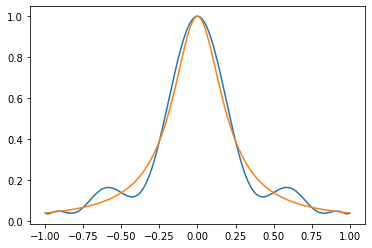

In [5]:
x = np.linspace(-1,1,1000)
xint = np.linspace(-1,1,5)
bary = Barycentric(xint,Runge(xint))
xint2 = np.array([-0.95,-0.9,-0.75,-0.25,0.25,0.75,0.9,0.95])
bary.add_weights(xint2,Runge(xint2))

plt.plot(x,bary(x))
plt.plot(x,Runge(x))

In [6]:
# Problem 5
def prob5():
    """For n = 2^2, 2^3, ..., 2^8, calculate the error of intepolating Runge's
    function on [-1,1] with n points using SciPy's BarycentricInterpolator
    class, once with equally spaced points and once with the Chebyshev
    extremal points. Plot the absolute error of the interpolation with each
    method on a log-log plot.
    """
    #domain
    x = np.linspace(-1,1,400)
    #ns
    N = [2**i for i in range(2,9)]
    #Runge
    f = lambda x: 1/(1+25 * x**2)
    #initializing list to hold error values
    Errors1 = []
    Errors2 = []
    
    fig, axs = plt.subplots(nrows=7,ncols=2)
    fig.set_size_inches(25, 15.5)
    plt.tight_layout()
    
    for i, n in enumerate(N):
        #n equally spaced points
        pts =  np.linspace(-1, 1, n)
        cheb_pts = np.array([ np.cos(j * np.pi/n) for j in range(n+1)   ])
        
        #creating interpolating polynomials
        poly = BarycentricInterpolator(pts)
        cheb_poly = BarycentricInterpolator(cheb_pts)
        poly.set_yi(f(pts))
        cheb_poly.set_yi(f(cheb_pts))
        fx = f(x)
        px = poly(x)
        cpx = cheb_poly(x)
        
        #finding errors
        error1 = np.linalg.norm((fx-px),ord=np.inf)
        error2 = np.linalg.norm((fx-cpx),ord=np.inf)
        Errors1.append(error1)
        Errors2.append(error2)
        
        #plotting
        axs[i][0].plot(x, fx,'r',label='Runge')
        axs[i][0].plot(x, px,'b',label='Uniform Interp Poly')
        axs[i][0].set_title("n = "+str(n))
        axs[i][1].plot(x, fx,'r',label='Runge')
        axs[i][1].plot(x, cpx,'darkgreen',label='Chebyshev Interp Poly')
        axs[i][1].set_title("n = "+str(n))
        if i <= 1:
            axs[i][0].legend()
            axs[i][1].legend()
    plt.show()        
    
    #plotting errors on loglog scale
    plt.title("Plotting Errors against n values")
    plt.loglog(N,Errors1,'b',label="Uniformly Spaced Interpolating Error")
    plt.loglog(N,Errors2,'darkgreen',label="Chebyshev Points Interpolating Error")
    plt.legend()

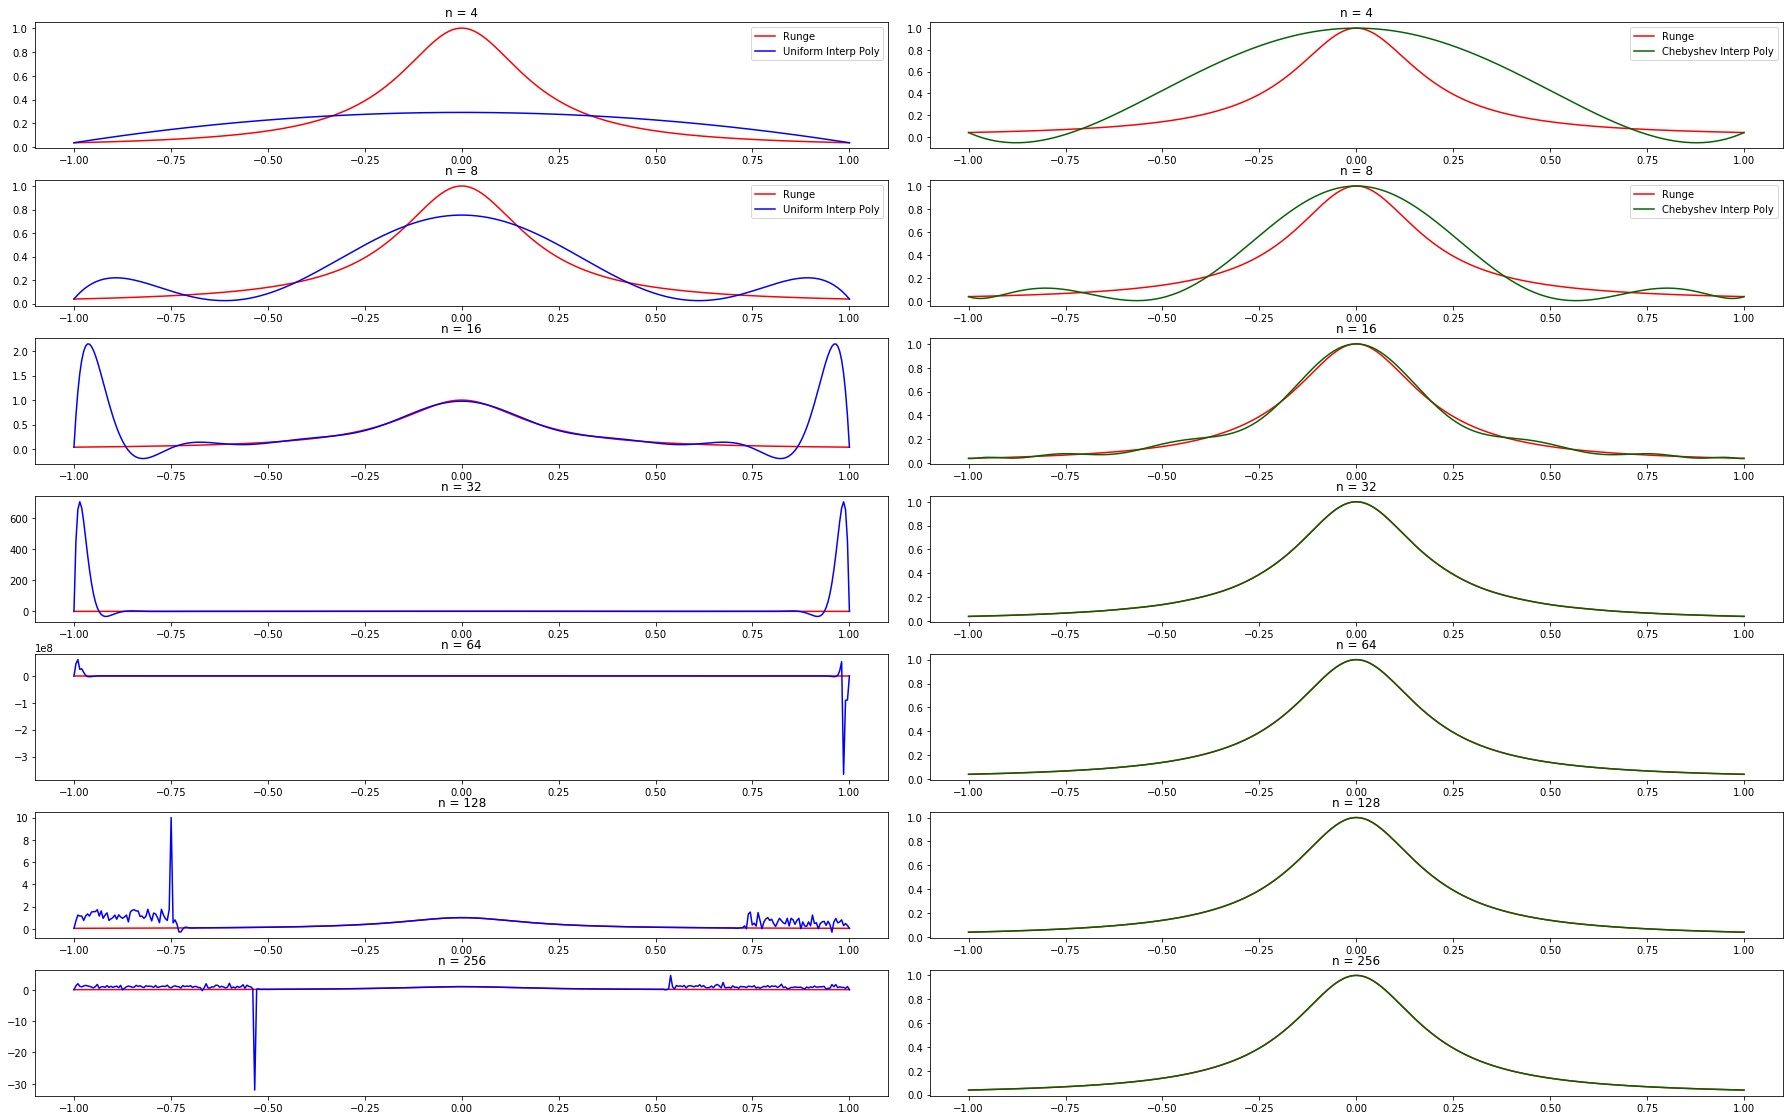

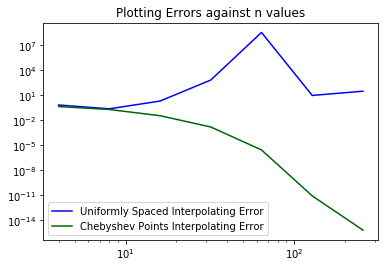

In [7]:
prob5()

In [8]:
# Problem 6
def chebyshev_coeffs(f, n):
    """Obtain the Chebyshev coefficients of a polynomial that interpolates
    the function f at n points.

    Parameters:
        f (function): Function to be interpolated.
        n (int): Number of points at which to interpolate.

    Returns:
        coeffs ((n+1,) ndarray): Chebyshev coefficients for the interpolating polynomial.
    """
    #cheb extremizers
    y = np.cos((np.pi*np.arange(2*n)) / n)
    samples = f(y)
    
    #coefficients for polynomial
    a = np.real(fft(samples))[:n+1] / n
    a[0] = a[0]/2
    a[n] = a[n]/2
    
    return a

In [9]:
f =lambda x: -3 + 2*x**2 - x**3 + x**4

In [10]:
chebyshev_coeffs(f, 3)

array([-1.625, -0.75 ,  1.625, -0.25 ])

In [18]:
# Problem 7
def prob7(n):
    """Interpolate the air quality data found in airdata.npy using
    Barycentric Lagrange interpolation. Plot the original data and the
    interpolating polynomial.

    Parameters:
        n (int): Number of interpolating points to use.
    """
    #loading data
    data = np.load('airdata.npy')
    
    fx = lambda a, b, N: .5*(a+b + (b-a) * np.cos(np.arange(N+1) * np.pi / N))
    a, b = 0, 366 - 1/24
    domain = np.linspace(0, b, 8784)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    poly = Barycentric(domain[temp2], data[temp2])
    
    plt.plot(domain,poly(domain))
    plt.scatter(domain,data,marker=',',color='r',s=1)
    plt.title("Polynomial Interpolation of Air Quality Data")
    plt.show()

[ 0.00475276 -0.00974589  0.01005913 -0.01013356  0.01010968 -0.01009493
  0.01004133 -0.0099949   0.00998058 -0.00998115  0.01002942 -0.01005966
  0.0100574  -0.01002706  0.01000855 -0.01000014  0.00997497 -0.00996441
  0.00999426 -0.01002255  0.01000931 -0.00996659  0.00997318 -0.00998613
  0.00997985 -0.01001206  0.01001614 -0.01000429  0.00998531 -0.00997571
  0.01001669 -0.01002876  0.00999961 -0.00996912  0.0099792  -0.01000402
  0.01001212 -0.0100304   0.01006054 -0.01006264  0.01003224 -0.00998384
  0.00998317 -0.00999742  0.01004379 -0.01009734  0.01011206 -0.01013591
  0.01006144 -0.00974812  0.00475385]


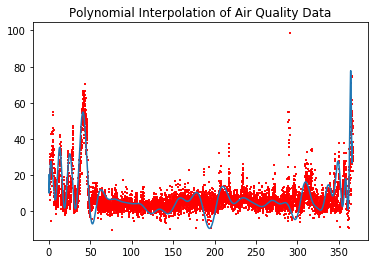

In [19]:
prob7(50)